# Mugration Analysis

---
## Objectives

1. Run mugration analysis on select traits.
1. Add mugration results to dataframe.
1. Plot confidence boxplots.
1. Plot colored trees.

---
## Setup

### Module Imports

In [1]:
from Bio import Phylo
from treetime.utils import parse_dates
from treetime import wrappers

import copy
import os
import sys
import IPython
import io

import pandas as pd
import numpy as np
import math

from geopy.distance import great_circle

import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches, gridspec
import seaborn as sns

import augur

### Input File Paths

In [2]:
tree_path = "../../docs/results/latest/branch_support/branch_support.xml"
tree_df_path = "../../docs/results/latest/branch_support/branch_support.tsv"
outdir = "../../docs/results/latest/mugration/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [3]:
# Metadata
NAME_COL = "Sample"
DATES_COL = "Date"

ATTRIBUTE_LIST = ["Branch_Major"]
# Province takes a long time...
"""
ATTRIBUTE_LIST = [
    "Branch_Major", 
    "Branch_Minor",
    "Country",
    "Province",
    "Biovar"
    ]
"""
NO_DATA_CHAR = "NA"

BRANCH_LEN_SIG_DIG = 12

MUG_CONF_THRESH = 0.95

SCRIPT_NAME = "mugration"

### Plotting Configuration

In [4]:
# Colors
HIGH_COL = "red"
LOW_COL = "black"
TERM_COL = "grey"
THRESH_COL = "blue"
# matplotlib for rainbow
COLOR_PAL = "rainbow"
# sns for everything else (see bottom of notebook)
#COLOR_PAL = "ch:s=.25,rot=-.25"

# Graphics
figsize=(6.4,4.8)
figsize_alt=(9.6,4.8)
dpi=400

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
#plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels

# Lines
plt.rc('lines', linewidth=0.5)

FMT="svg"

---
## Analysis

### Read Input Tree and Dataframe

In [5]:
tree_div = Phylo.read(tree_path, "phyloxml")
tree_div.ladderize(reverse=False)

tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

---
## Mugration

In [6]:
# Optional: simplify the Mictorus biovar
biovar_microtus_sub = ["Ulegeica", "Altaica", "Talassica", "Hissarica", "Xilingolensis", "Caucasica"]
tree_df.replace(biovar_microtus_sub, "Microtus", inplace=True)

In [7]:
mug_dict = {}

for attr in ATTRIBUTE_LIST:
    mug_dict[attr] = {}
    # Make a copy of the input tree
    mug_dict[attr]["tree_div"] = copy.deepcopy(tree_div)
    # Map the taxon name to the attribute for mugration analysis
    mug_dict[attr]["leaf_to_attr"] = {sample:str(data[attr]) for sample,data in tree_df.iterrows()
                    if data[attr]!=NO_DATA_CHAR and data[attr]}    
    # Make blank dicts for the mugration output
    mug_dict[attr]["tree_mug"] = {}
    mug_dict[attr]["letter_to_state"] = {}
    mug_dict[attr]["reverse_alphabet"] = {}
    mug_dict[attr]["unique_states"] = {}

### Run mugration to capture log

In [9]:
for attr in ATTRIBUTE_LIST:
    print("Running mugration for attribute: {}".format(attr))
    # Initialize stdout capture
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout
    
    # Run mugration
    mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(mug_dict[attr]["tree_div"], 
                                                                     traits=mug_dict[attr]["leaf_to_attr"], 
                                                                     missing_data=NO_DATA_CHAR,
                                                                     #missing_data="nan",
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
    mug_dict[attr]["tree_mug"] = mug
    mug_dict[attr]["letter_to_state"] = letter_to_state
    mug_dict[attr]["reverse alphabet"] = reverse_alphabet
    mug_dict[attr]["unique_states"] = sorted(letter_to_state.values())
    
    # Save stdout to file
    output = new_stdout.getvalue()
    out_path = os.path.join(outdir, SCRIPT_NAME + "_{}.log".format(attr.lower())) 
    with open(out_path, "w") as file:
        file.write(output)
    # Restore stdout
    sys.stdout = old_stdout
    print("stoud restored, logging to file disabled.")

Running mugration for attribute: Branch_Major
Stoud restored, logging to file disabled.


### Add mugration to dataframe

In [10]:
for attr in ATTRIBUTE_LIST:
    # Initialize empty values for the new mugration attribute and its confidence
    tree_df["Mugration_" + attr] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    tree_df["Mugration_" + attr + "_Confidence"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]    
    
    tree_mug = mug_dict[attr]["tree_mug"].tree
    unique_states = mug_dict[attr]["unique_states"]

    # Iterate through the nodes in the tree
    for c in tree_mug.find_clades():
        # Store the name and confidence for the state with the most support
        state_max_name = mug_dict[attr]["letter_to_state"][c.cseq[0]]
        state_conf_list = c.marginal_profile[0]
        state_max_conf = max(state_conf_list)
        c.other = []

        # Store all the states and confidence values
        for state_name,state_conf in zip(unique_states, state_conf_list):
            attr_other = Phylo.PhyloXML.Other(tag=state_name, value="{:0.4f}".format(state_conf), namespace=attr)
            c.other.append(attr_other)

        # Store the Maximum assigned value
        attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(state_max_conf), namespace=attr + "_assign")
        c.other.append(attr_other)
    
        if c.name in tree_df.index:
            tree_df.at[c.name, "Mugration_" + attr] = state_max_name
            tree_df.at[c.name, "Mugration_" + attr + "_Confidence"] = state_max_conf

---
## Plotting

### Mugration Boxplots

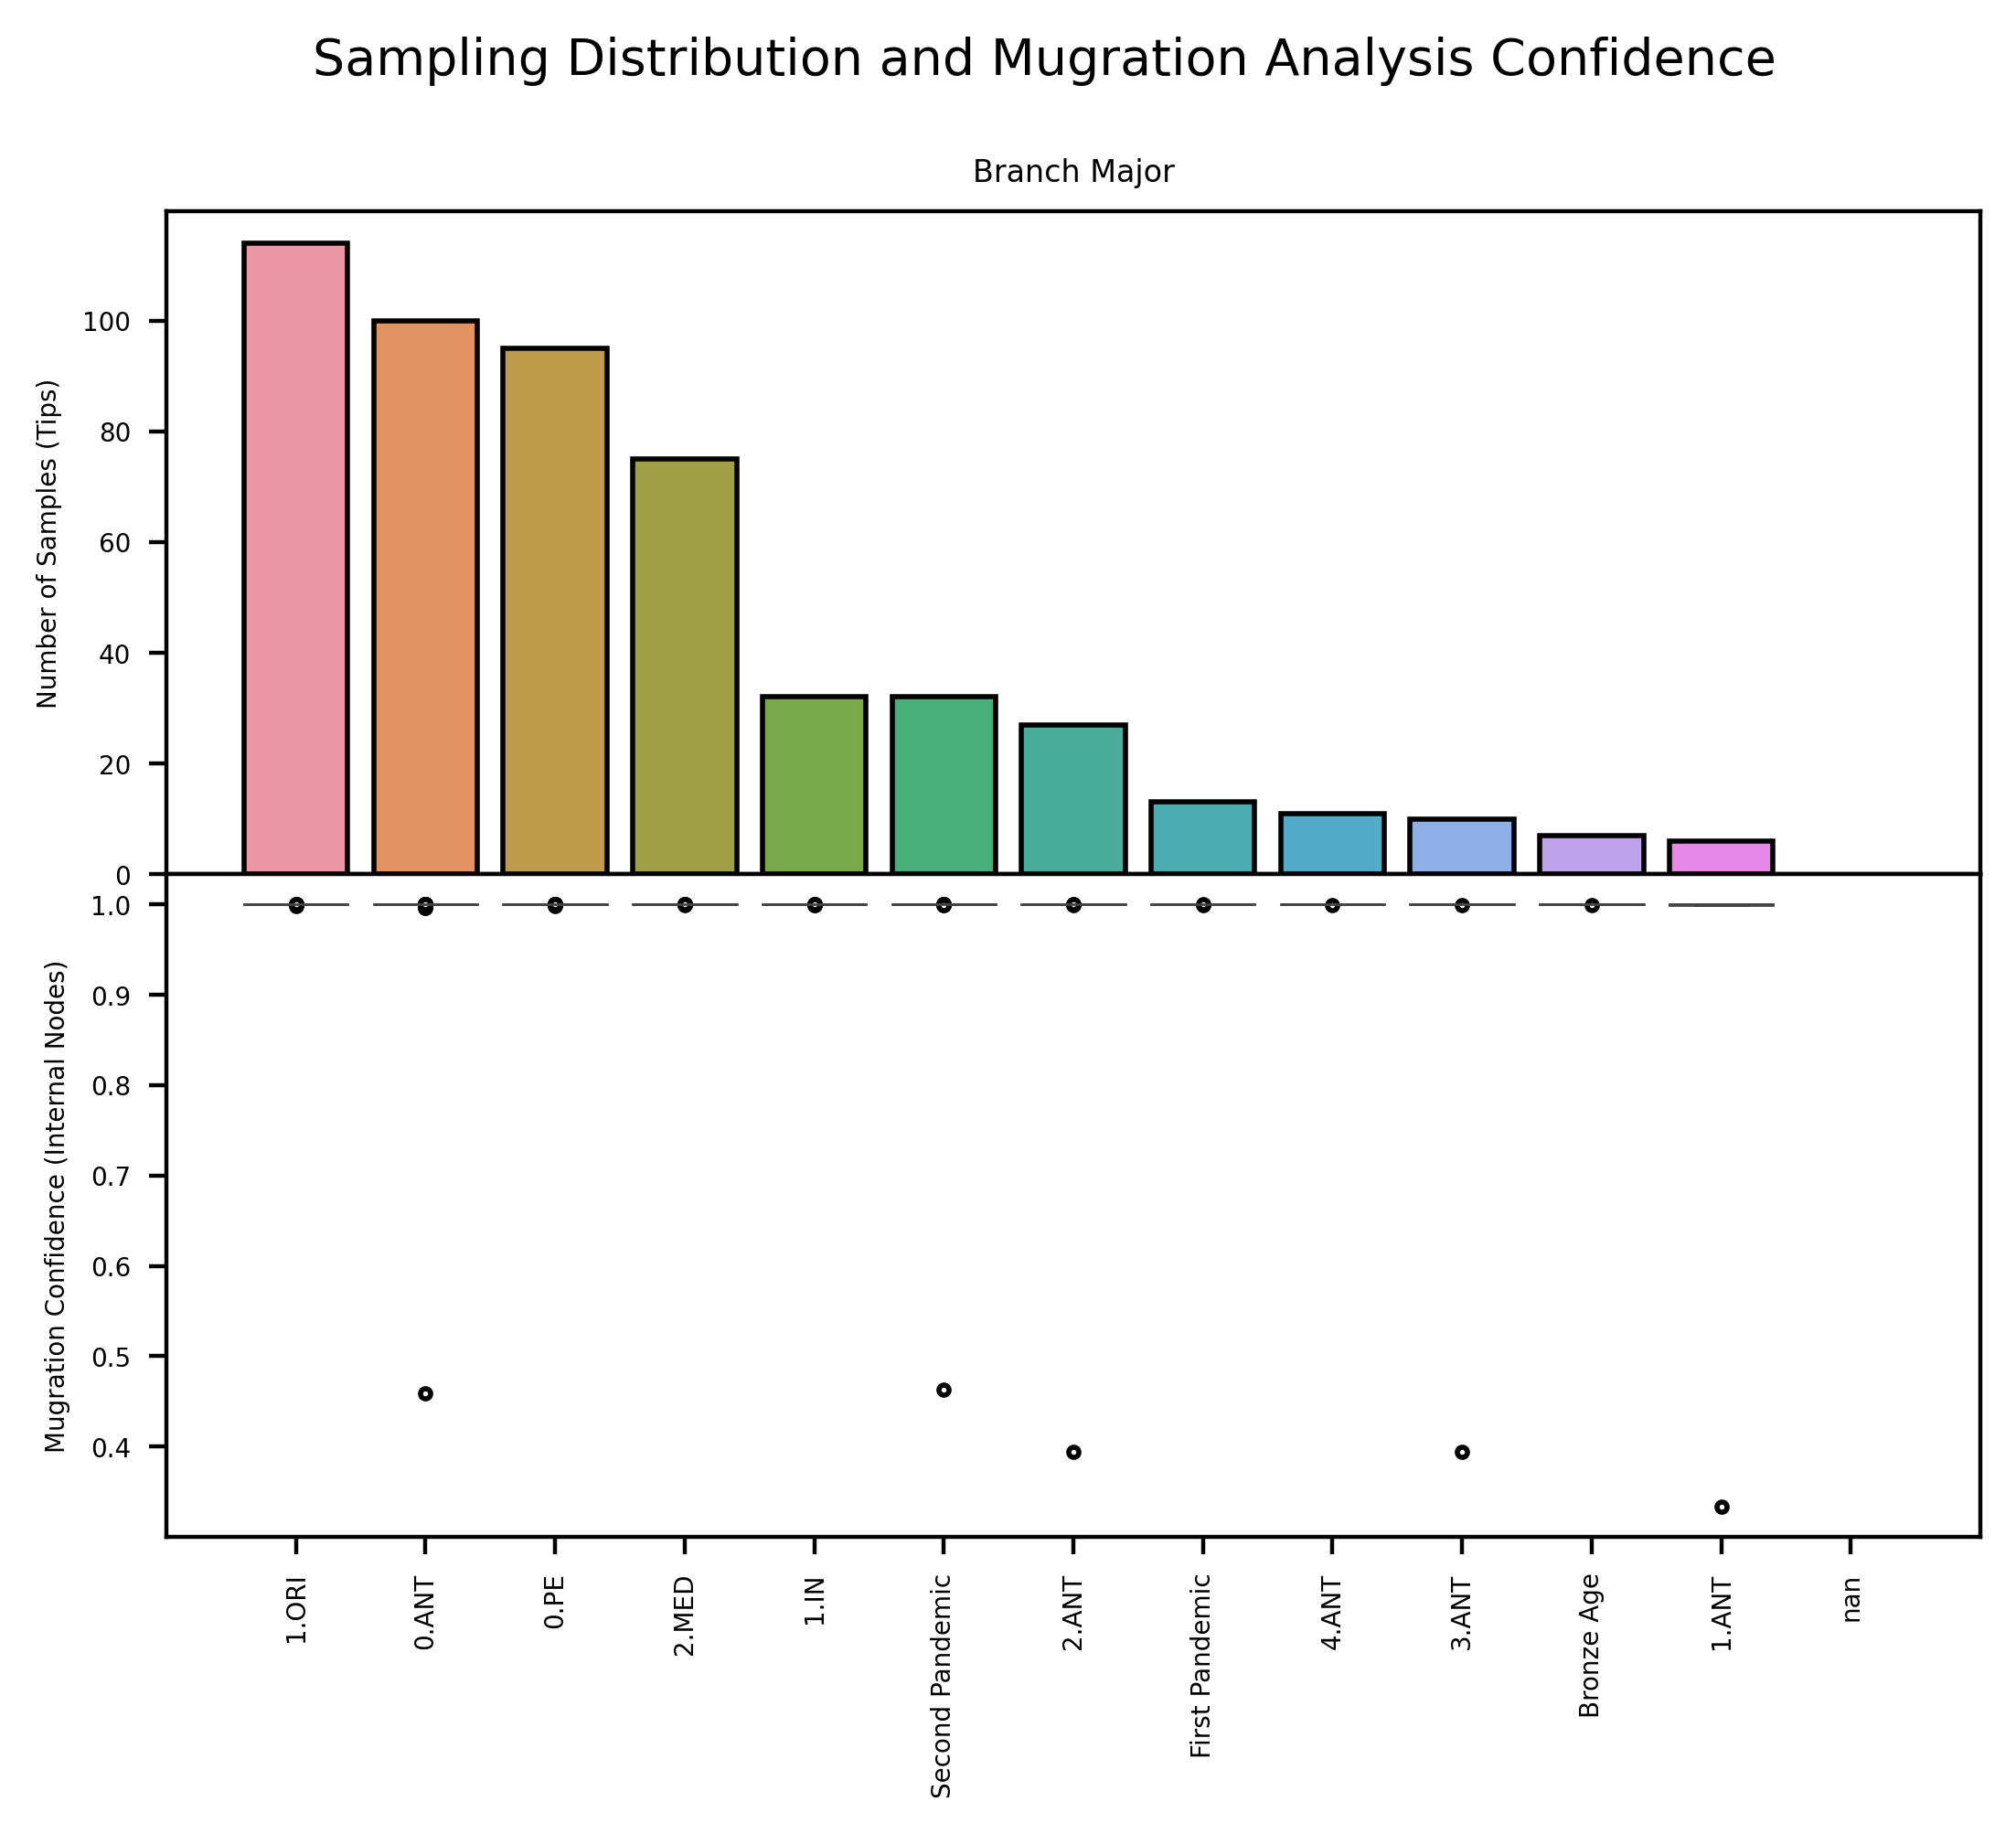

In [11]:
for attr in ATTRIBUTE_LIST:
    fig, (ax1, ax2) = plt.subplots(2, 
                               sharex=False, 
                               gridspec_kw={'hspace': 0},
                               figsize=figsize, 
                               dpi=dpi,
                               #constrained_layout=True,
                              )
    
    # --------------------------
    # Axis 1 - Number of tips per state
    # Exclude samples with no attribute recorded
    data = tree_df[tree_df[attr] != NO_DATA_CHAR]
    label_order = list(data[attr].value_counts().index)
    label_order = [lab for lab in label_order if lab != "nan"] + ["nan"]
    sns.countplot(data=data, 
                  x=attr, 
                  #color="blue", 
                  edgecolor="black",
                  ax=ax1, 
                  order=label_order)
    plt.setp(ax1.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax1.get_xticklabels()]
    ax1.set_xticklabels(xticklabels, rotation = 90, ha="right")
    ax1.set_xlabel("")
    ax1.set_ylabel("Number of Samples (Tips)")
    ax1.set_xlim(-1,len(label_order)) 
    ax1.set_title(attr.replace("_"," "))
    
    # --------------------------
    # Axis 2 - Mugration Confidence
    # Exclude nodes that are terminals (ie. branch support is grey)
    data = tree_df[tree_df["Branch_Support_Color"] != "grey"]
    # Customize outlier style
    flierprops = dict(marker='o', markerfacecolor='white', markersize=2,
                      linestyle='none', markeredgecolor='black')
    # Create a boxplot
    sns.boxplot(data=data, 
                  x="Mugration_" + attr, 
                  y="Mugration_" + attr + "_Confidence",
                  #color="blue", 
                  ax=ax2, 
                  order=label_order,
                  flierprops=flierprops)
    #plt.setp(ax2.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax2.get_xticklabels()]
    ax2.set_xticklabels(xticklabels, rotation = 90, ha="center")
    #ax2.axhline(y=MUG_CONF_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
    ax2.set_xlabel("")
    ax2.set_ylabel("Mugration Confidence (Internal Nodes)")
    ax2.set_xlim(-1,len(label_order))
    
    fig.suptitle("Sampling Distribution and Mugration Analysis Confidence")
    
    out_path = os.path.join(outdir, SCRIPT_NAME + "_boxplot_{}.{}".format(attr.lower(), FMT)) 
    plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

### Color branches on mug/div tree according to state

In [12]:
for attr in ATTRIBUTE_LIST:
    tree_mug = mug_dict[attr]["tree_mug"].tree
    unique_states = mug_dict[attr]["unique_states"]
    
    # Initialize the states
    ordered_states = []
    
    # Get the order of attributes
    for t in tree_mug.get_terminals():
        for prop in t.other:
            if prop.namespace == attr + "_assign" and prop.tag not in ordered_states:
                ordered_states.append(prop.tag)
    
    # Number of states that need colors (exclude nan)
    num_attr = len(unique_states[:-1])

    # Create the custom color map (pyplot)
    cmap = plt.get_cmap(COLOR_PAL,num_attr)
    cmaplist = [cmap(i) for i in range(cmap.N)]
    
    # Create the custom color map (seaborn)    
    #cmaplist = sns.color_palette("husl", num_attr)   
    # force the first color entry to be grey
    #num_attr = num_attr + 1

    # create the new map
    cmap = colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, num_attr)
    
    cmaplist = cmap(np.linspace(0, 1, num_attr))
    hex_list = [colors.to_hex(col) for col in cmaplist]

    hex_dict = {}

    # Assign states colors based on tip order (Low Conf first as grey)
    for state,hex_col in zip(ordered_states, hex_list):
        hex_dict[state] = hex_col

    # OPTIONAL: Add Low confidence grey to colormap
    hex_dict["Low Confidence"] = "grey"
    
    # Add the hex color dict to the dict
    mug_dict[attr]["hex_color"] = hex_dict
                     
    print(hex_dict)

{'Bronze Age': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', 'First Pandemic': '#0cc1e8', '3.ANT': '#3ae8d7', '4.ANT': '#68fcc1', '2.ANT': '#97fca7', '2.MED': '#c5e88a', 'Second Pandemic': '#f3c16a', '1.ANT': '#ff8a48', '1.IN': '#ff4824', '1.ORI': '#ff0000', 'Low Confidence': 'grey'}


### Plot divergence tree colored by mugration

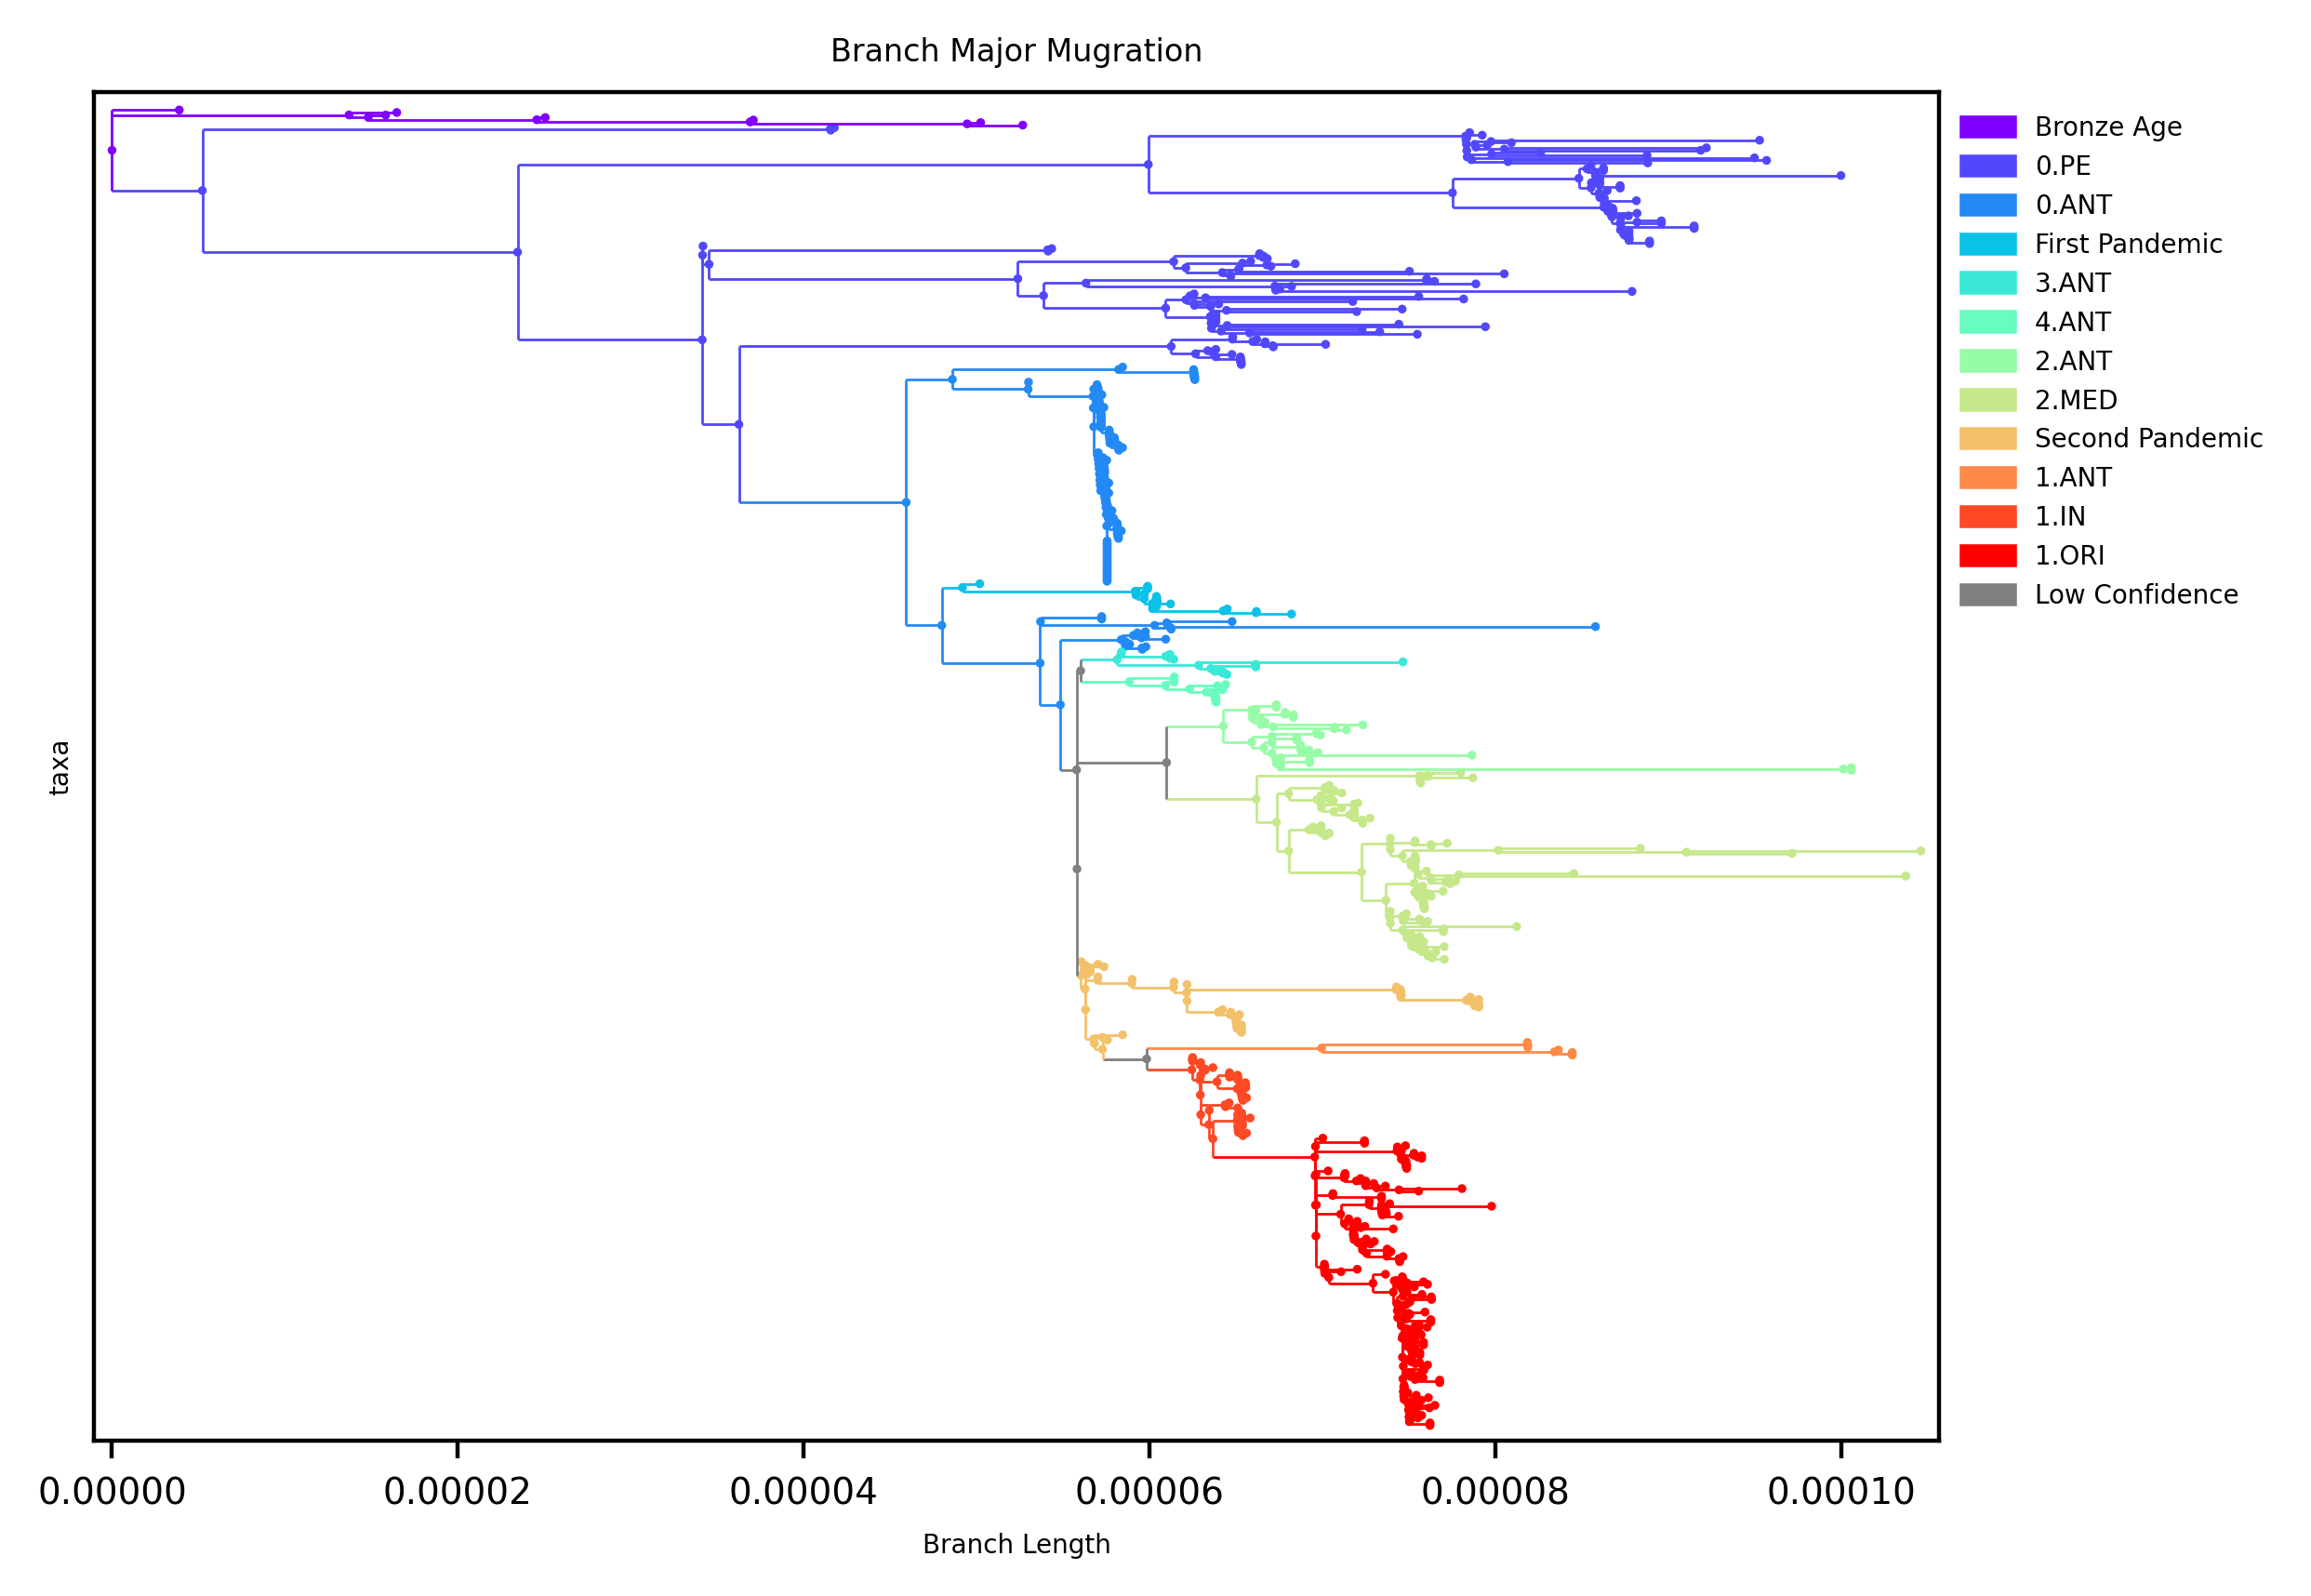

In [15]:
for attr in ATTRIBUTE_LIST:  
    # Going to store mugration color in df
    tree_df["Mugration_" + attr + "_Color"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
    # Change the branch color
    for c in tree_div.find_clades():
        attr_val = tree_df["Mugration_" + attr][c.name]
        attr_color = mug_dict[attr]["hex_color"][attr_val]
        # OPTIONAL: Color grey if low confidence
        if tree_df["Mugration_" + attr + "_Confidence"][c.name] < MUG_CONF_THRESH:
            attr_color = "grey"        
        c.color = attr_color
        tree_df.at[c.name, "Mugration_" + attr + "_Color"] = attr_color
      
    
    largest_div = max(tree_div.depths().values())
                      
    fig = plt.figure(dpi=dpi, figsize=figsize)
    ax = plt.subplot()

    # Draw tree to the canvas 
    Phylo.draw(tree_div,
               axes=ax, 
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)

    # Plot the tips
    ax.scatter(data=tree_df, x="coord_x", y="coord_y", s=0.5, c="Mugration_" + attr + "_Color",)
    
    # Ticks
    x_buffer = max(tree_df["coord_x"]) * 0.01
    y_buffer = math.ceil(len(tree_div.get_terminals()) * 0.01)

    ax.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)    
    ax.set_ylim(len(tree_div.get_terminals()) + y_buffer, 0 - y_buffer)
    ax.set_yticks([])
    plt.xticks(fontsize=7)

    # Labels
    plt.xlabel("Branch Length")
    #plt.ylabel("Taxa")
    plt.title("{} Mugration".format(attr.replace("_"," ")))

    # Legend
    legend_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in mug_dict[attr]["hex_color"].values()]
    legend_labels = list(mug_dict[attr]["hex_color"].keys())

    ax.legend(legend_elements, 
              legend_labels,
              bbox_to_anchor=(1.0, 1.0), 
              loc='upper left',
              frameon=False,
             )

    # Write to file
    out_path = os.path.join(outdir, SCRIPT_NAME + "_tree_{}.{}".format(attr.lower(), FMT))  
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
## Test

### Color Palette Browsing

In [ ]:
num_attr = 11

In [ ]:
sns.color_palette("husl", 12)

In [ ]:
sns.color_palette("flare", 
                  num_attr, 
                  #as_cmap=True
                 )

In [ ]:
sns.color_palette("ch:s=.25,rot=-.25", 
                  num_attr,
                  #as_cmap=True,
                 )

In [ ]:
sns.color_palette("rocket",
                 num_attr,
                 )

In [ ]:
sns.color_palette("Spectral", num_attr)

---
## Export

### Save tree and dataframe

In [17]:
# Save tree dataframe with mugration info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

out_path_xml = os.path.join(outdir,  SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tree_div, out_path_xml, 'phyloxml')
Phylo.write(tree_div, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tree_div, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

### JSON

This can then be used for auspice via:

```
augur export v2 \
  --auspice-config auspice.config \
  --tree mugration.nwk \
  --node-data mugration.json \
  --output mugration_auspice.json
```

In [18]:
# Exclude these internal variables for plotting
COLOR_KEYWORD_EXCLUDE = ["color", "coord", "confidence"]

In [20]:
# There is no alignment used
node_data = {"alignment" : ""}
node_data["input_tree"] = tree_path

node_dict = {}

# Iterate through all nodes in the tree
for c in tree_div.find_clades():
    # Add the node to the dictionary
    node_dict[c.name] = {}
    # Iterate through all attributes in the dataframe
    for attr in tree_df.columns:
        # Test confidence
        #if attr == "Mugration_Branch_Major_Confidence":
        #    node_dict[c.name][attr.lower()] = tree_df[attr][c.name]
        # Check if this attribute should be excluded
        exclude = False
        for keyword in COLOR_KEYWORD_EXCLUDE:
            if keyword in attr.lower():
                exclude = True    
        if not exclude:            
            # Make attribute name in dict lowercase (ex. Branch_Length -> branch_length)
            node_dict[c.name][attr.lower()] = tree_df[attr][c.name]

        
# Add the dataframe information to the node dict for the json
node_data["nodes"] = node_dict

out_path_json = os.path.join(outdir, SCRIPT_NAME + ".json" )
augur.utils.write_json(data=node_data, file_name=out_path_json, indent=2)